# <center>Classify Default Clients - Credit Card Data<center>
<center>$\it{Developed~by~Anghsuan~Wu}$</center>


<center><img src="credit_card.svg" width="700"></center>

## Data Overview: __[[Reference: UCI Machine Learning Repository]](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients#)__

- DEFAULT: Whether the user default the next month payment (No = 0, Yes = 1).
- LIMIT_BAL: Amount of the given credit (NT dollar). It includes both the individual consumer credit and his/her family (supplementary) credit.
- SEX: Male of female (1 = male, 2 = female).
- EDUCATION: Consumer's highest education level (1 = graduate school; 2 = university; 3 = high school; 4 = others).
- MARRIAGE: Marital status (1 = married; 2 = single; 3 = divorce; 4 = others).
- AGE: Age in year.
- PAY_0 to PAY_6: History of past payment (-2 = no consumption; -1 = pay duly; 0 = the use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above).
- BILL_AMT1 to BILL_AMT6: Amount of bill statement (NT dollar).
- PAY_AMT1 to PAY_AMT6: Amount of previous payment (NT dollar).

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from itertools import product
from sklearn.utils import resample
import scipy.stats as ss
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

In [7]:
raw_df = pd.read_csv('dccc.csv', index_col=0)
col = raw_df.columns.tolist()
col = col[-1:] + col[:-1]
raw_df = raw_df[col]
col_dict = {
    'default payment next month': 'DEFAULT',
    'PAY_0': 'PAY_9',
    'PAY_2': 'PAY_8',
    'PAY_3': 'PAY_7',
    'PAY_4': 'PAY_6',
    'PAY_5': 'PAY_5',
    'PAY_6': 'PAY_4',
    'BILL_AMT1': 'BILL_AMT9',
    'BILL_AMT2': 'BILL_AMT8',
    'BILL_AMT3': 'BILL_AMT7',
    'BILL_AMT4': 'BILL_AMT6',
    'BILL_AMT5': 'BILL_AMT5',
    'BILL_AMT6': 'BILL_AMT4',
    'PAY_AMT1': 'PAY_AMT9',
    'PAY_AMT2': 'PAY_AMT8',
    'PAY_AMT3': 'PAY_AMT7',
    'PAY_AMT4': 'PAY_AMT6',
    'PAY_AMT5': 'PAY_AMT5',
    'PAY_AMT6': 'PAY_AMT4'
}
raw_df = raw_df.rename(col_dict, axis=1)

In [8]:
raw_df.head()

,DEFAULT,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_9,PAY_8,PAY_7,PAY_6,...,BILL_AMT7,BILL_AMT6,BILL_AMT5,BILL_AMT4,PAY_AMT9,PAY_AMT8,PAY_AMT7,PAY_AMT6,PAY_AMT5,PAY_AMT4
ID,,,,,,,,,,,,,,,,,,,,,
1,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
2,1,120000,2,2,2,26,-1,2,0,0,...,2682,3272,3455,3261,0,1000,1000,1000,0,2000
3,0,90000,2,2,2,34,0,0,0,0,...,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000
4,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
5,0,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679


## Data Preprocessing
This section contains:
- Dealing with missing value
- Explore the data with visualization
- Data scaling

###  Missing Values

In [9]:
np.random.seed(123)
rows = np.random.randint(0, 30000, 10000)
df = raw_df.loc[rows].copy().reset_index(drop=True)

# Randomly replace 6% of records with NaN
df.iloc[:, 1:] = df.iloc[:, 1:].mask(
    np.random.random((df.shape[0], df.shape[1] - 1)) < 0.06)
tot_nan = df.isnull().sum().sum()

print('The distribution of NaN across each column:')
print(df.isnull().sum())
print(
    '\nAfter randomly replacing missing values, we now have {0} NaN\'s across the dataset, it\'s approximate to the proportion of {1:.1%} in the dataset.'
    .format(tot_nan, tot_nan / (df.shape[0] * df.shape[1])))

The distribution of NaN across each column:
DEFAULT        0
LIMIT_BAL    568
SEX          586
EDUCATION    641
MARRIAGE     584
AGE          600
PAY_9        630
PAY_8        585
PAY_7        592
PAY_6        584
PAY_5        615
PAY_4        581
BILL_AMT9    595
BILL_AMT8    569
BILL_AMT7    604
BILL_AMT6    546
BILL_AMT5    604
BILL_AMT4    593
PAY_AMT9     612
PAY_AMT8     590
PAY_AMT7     617
PAY_AMT6     605
PAY_AMT5     571
PAY_AMT4     551
dtype: int64

After randomly replacing missing values, we now have 13623 NaN's across the dataset, it's approximate to the proportion of 5.7% in the dataset.


In [10]:
df.fillna(df.median(), inplace=True)

# Check NULL values
print('After dealing with missing values, we got {} NaN now.'.format(df.isnull().sum().sum()))

After dealing with missing values, we got 0 NaN now.


### Exploratory Data Analysis

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   DEFAULT    10000 non-null  int64  
 1   LIMIT_BAL  10000 non-null  float64
 2   SEX        10000 non-null  float64
 3   EDUCATION  10000 non-null  float64
 4   MARRIAGE   10000 non-null  float64
 5   AGE        10000 non-null  float64
 6   PAY_9      10000 non-null  float64
 7   PAY_8      10000 non-null  float64
 8   PAY_7      10000 non-null  float64
 9   PAY_6      10000 non-null  float64
 10  PAY_5      10000 non-null  float64
 11  PAY_4      10000 non-null  float64
 12  BILL_AMT9  10000 non-null  float64
 13  BILL_AMT8  10000 non-null  float64
 14  BILL_AMT7  10000 non-null  float64
 15  BILL_AMT6  10000 non-null  float64
 16  BILL_AMT5  10000 non-null  float64
 17  BILL_AMT4  10000 non-null  float64
 18  PAY_AMT9   10000 non-null  float64
 19  PAY_AMT8   10000 non-null  float64
 20  PAY_AMT

In [12]:
col = ['DEFAULT', 'SEX', 'EDUCATION', 'MARRIAGE']
for c in col:
    df[c] = df[c].astype('category')

col = ['PAY_9', 'PAY_8', 'PAY_7', 'PAY_6', 'PAY_5', 'PAY_4']
for c in col:
    df[c] = df[c].astype('int').astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 24 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   DEFAULT    10000 non-null  category
 1   LIMIT_BAL  10000 non-null  float64 
 2   SEX        10000 non-null  category
 3   EDUCATION  10000 non-null  category
 4   MARRIAGE   10000 non-null  category
 5   AGE        10000 non-null  float64 
 6   PAY_9      10000 non-null  category
 7   PAY_8      10000 non-null  category
 8   PAY_7      10000 non-null  category
 9   PAY_6      10000 non-null  category
 10  PAY_5      10000 non-null  category
 11  PAY_4      10000 non-null  category
 12  BILL_AMT9  10000 non-null  float64 
 13  BILL_AMT8  10000 non-null  float64 
 14  BILL_AMT7  10000 non-null  float64 
 15  BILL_AMT6  10000 non-null  float64 
 16  BILL_AMT5  10000 non-null  float64 
 17  BILL_AMT4  10000 non-null  float64 
 18  PAY_AMT9   10000 non-null  float64 
 19  PAY_AMT8   10000 non-null 

In [13]:
df.describe()

,LIMIT_BAL,AGE,BILL_AMT9,BILL_AMT8,BILL_AMT7,BILL_AMT6,BILL_AMT5,BILL_AMT4,PAY_AMT9,PAY_AMT8,PAY_AMT7,PAY_AMT6,PAY_AMT5,PAY_AMT4
count,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000
mean,165588.368000,35.297000,50580.707100,48388.728600,4.652091e+04,43334.188200,40094.888600,38580.967400,5377.23710,5.812295e+03,5279.373900,4889.957300,4574.359200,5289.660800
std,125330.308266,8.783126,73210.966831,70930.493817,6.955658e+04,64562.849713,60858.697312,59962.464487,16296.46212,2.638574e+04,18514.181081,17024.474558,14535.738988,19529.214551
min,10000.000000,21.000000,-10682.000000,-18618.000000,-6.150600e+04,-170000.000000,-81334.000000,-339603.000000,0.00000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,60000.000000,28.000000,4131.000000,3658.750000,3.587500e+03,3119.750000,2457.000000,1615.750000,1061.50000,1.000000e+03,600.000000,389.750000,329.750000,258.000000
50%,140000.000000,34.000000,23237.000000,21540.000000,2.061900e+04,19514.500000,18483.500000,17273.000000,2162.50000,2.089000e+03,2000.000000,1500.000000,1510.000000,1500.000000
75%,230000.000000,41.000000,63289.250000,60968.250000,5.841250e+04,52620.250000,49147.250000,47835.000000,5000.00000,5.000000e+03,4300.750000,4000.000000,4000.000000,4000.000000
max,800000.000000,73.000000,626648.000000,743970.000000,1.664089e+06,628699.000000,823540.000000,568638.000000,873552.00000,1.684259e+06,889043.000000,621000.000000,388071.000000,528666.000000


In [14]:
df.head()

,DEFAULT,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_9,PAY_8,PAY_7,PAY_6,...,BILL_AMT7,BILL_AMT6,BILL_AMT5,BILL_AMT4,PAY_AMT9,PAY_AMT8,PAY_AMT7,PAY_AMT6,PAY_AMT5,PAY_AMT4
0,0,270000.0,2.0,2.0,1.0,36.0,0,0,0,0,...,55382.0,46629.0,28115.0,12847.0,5168.0,5010.0,2005.0,2000.0,2000.0,2000.0
1,0,140000.0,1.0,2.0,2.0,38.0,0,0,0,2,...,142477.0,140617.0,139353.0,140953.0,6010.0,12500.0,4009.0,5000.0,1510.0,5300.0
2,0,50000.0,2.0,2.0,1.0,34.0,-2,-1,0,0,...,50710.0,50503.0,40140.0,-21364.0,50702.0,2033.0,1776.0,2000.0,29000.0,59901.0
3,0,220000.0,2.0,2.0,1.0,51.0,0,0,0,0,...,8605.0,5352.0,-5048.0,-5048.0,3010.0,3040.0,1000.0,0.0,0.0,0.0
4,1,100000.0,2.0,3.0,1.0,35.0,2,2,2,2,...,102698.0,97997.0,103384.0,97266.0,5500.0,8200.0,0.0,8000.0,0.0,8600.0


<font color='DARKGREEN'>__Re-define the categorical data__</font>

In [15]:
df['EDUCATION'].replace([0, 5, 6], 4, inplace=True)
df['MARRIAGE'].replace(0, 4, inplace=True)

<font color='DARKGREEN'>__Show the distribution between whether or not customers are default__</font>

There are 22.63% risky customers (targets) in our data.
The ratio of risky to non-risky is 29.25%


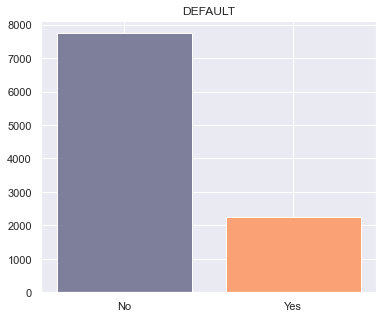

In [33]:
plt.figure(figsize=(6, 5))
x_axis = ['No', 'Yes']
y_axis = df['DEFAULT'].value_counts().tolist()
plt.bar(x_axis, y_axis, color=('#7e7f9a', '#faa275'))
plt.title('DEFAULT')
print('There are {:.2%} risky customers (targets) in our data.'.format(sum(df.DEFAULT)/len(df.DEFAULT)))
print('The ratio of risky to non-risky is {:.2%}'.format(df.DEFAULT.value_counts()[1]/df.DEFAULT.value_counts()[-2]))

<font color='DARKGREEN'>__Show the distribution on SEX, EDUCATION, and MARRIAGE variables grouped by DEFAULT.__</font>

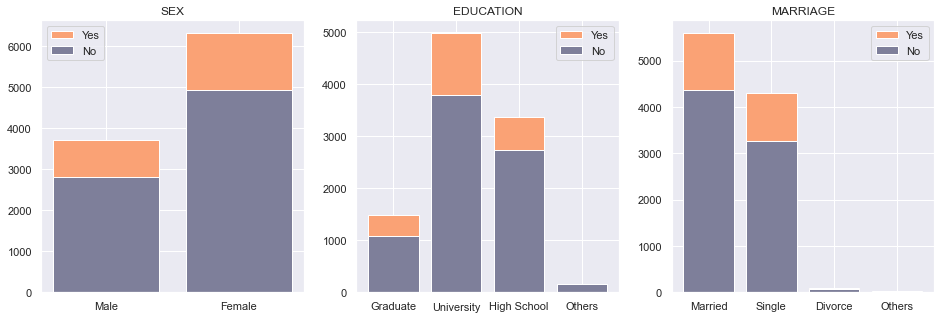

In [34]:
fig, axes = plt.subplots(ncols=3, nrows=1, figsize=(16, 5))

k = ['SEX', 'EDUCATION', 'MARRIAGE']
v = [['Male', 'Female'], ['Graduate', 'University', 'High School', 'Others'],
     ['Married', 'Single', 'Divorce', 'Others']]
p = [0, 1, 2]

for kol, val, pos in zip(k, v, p):
    plt.sca(axes[pos])
    x_axis = df[kol].unique().tolist()
    y_axis_0 = df[kol][df.DEFAULT == 0].value_counts().tolist()
    y_axis_1 = df[kol][df.DEFAULT == 1].value_counts().tolist()
    p1 = plt.bar(x_axis, y_axis_0, color='#7e7f9a')
    p2 = plt.bar(x_axis, y_axis_1, bottom=y_axis_0, color='#faa275')
    plt.title(kol)
    plt.legend((p2[0], p1[0]), ('Yes', 'No'), loc='best')
    plt.xticks(np.arange(1, len(val) + 1), val)

<font color='DARKGREEN'>__Show the distribution on LIMIT_BAL and AGE__</font>

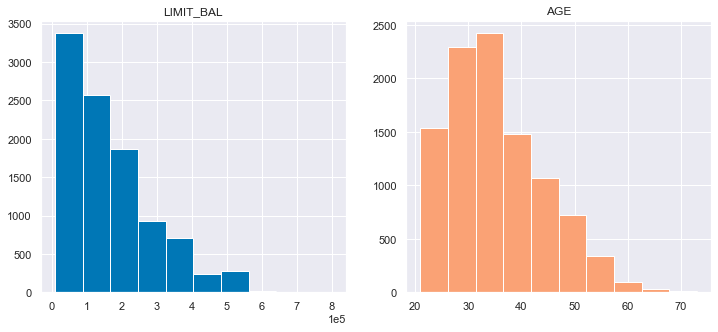

In [46]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))
k = ['LIMIT_BAL', 'AGE']
p = [0, 1]
c = ['#0077b6', '#faa275']

for kol, pos, col in zip(k, p, c):
    plt.sca(axes[pos])
    plt.hist(df[kol], color=col)
    plt.title(kol)
    plt.ticklabel_format(axis='x', style='sci', scilimits=(0, 5))

<font color='DARKGREEN'>__Show the distribution on AGE and LIMIT_BAL grouped by DEFAULT.__</font>

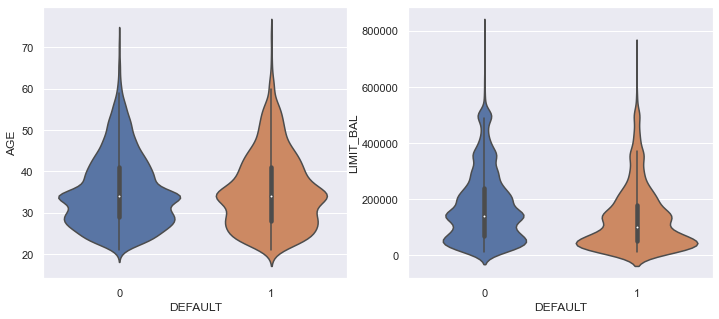

In [45]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

k = ['AGE', 'LIMIT_BAL']
p = [0, 1]

for kol, pos in zip(k, p):
    plt.sca(axes[pos])
    sns.violinplot(df.DEFAULT, df[kol])

<font color='DARKGREEN'>__Correlation between all numerical columns__</font>

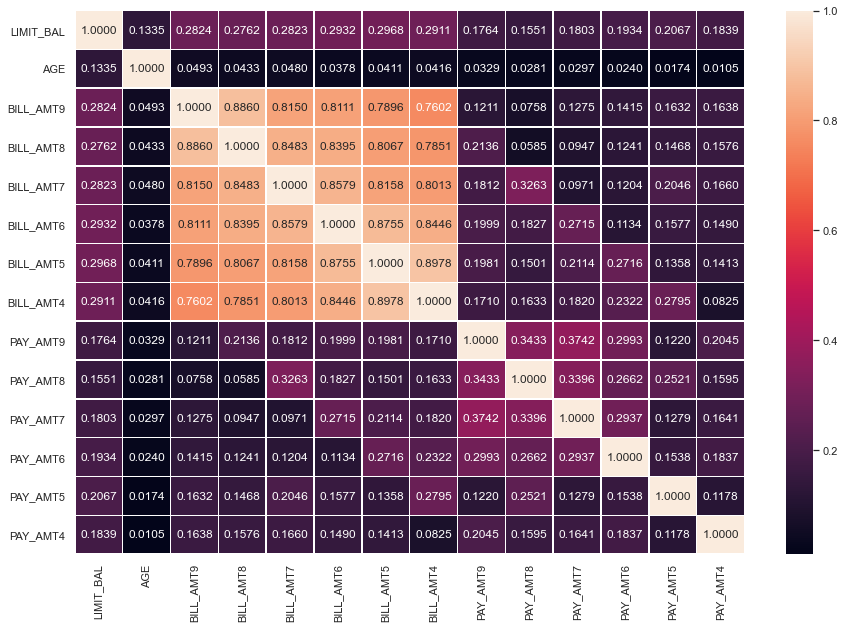

In [15]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), annot=True, fmt='.4f', linewidths=.5)
plt.show()

Remove high correlation features to avoid collinearity issue.

<font color='DARKGREEN'>__Correlation between all categorical columns__</font>

In [16]:
def cramers_v(x, y):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

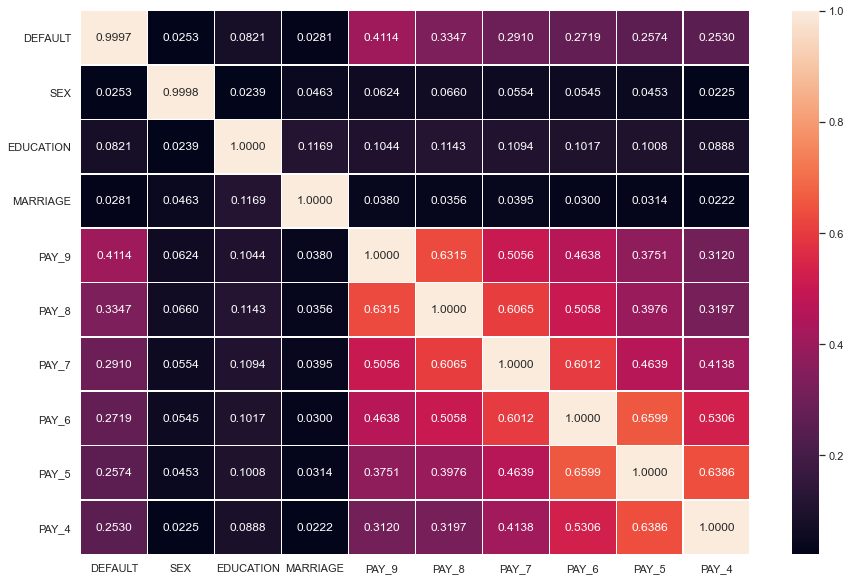

In [17]:
corr_mat_catcat = []
df_cat = df.select_dtypes(include = ['category'])
for i in df_cat.columns:
    for j in df_cat.columns:
        corr_mat_catcat.append(cramers_v(df[i], df[j]))

corr_mat_catcat = np.array(corr_mat_catcat).reshape(len(df_cat.columns), len(df_cat.columns))
corr_df_catcat = pd.DataFrame(corr_mat_catcat, index=df_cat.columns, columns=df_cat.columns)
plt.figure(figsize=(15, 10))
sns.heatmap(corr_df_catcat, annot=True, fmt='.4f', linewidths=.5)
plt.show()

To check data leakage issue, and also remove the irrelevant features.

<font color='DARKGREEN'>__One-way ANOVA on each numerical columns and target column__</font>

In [18]:
pos = df[df.DEFAULT == 1]
neg = df[df.DEFAULT == 0]
df_num = df.select_dtypes(include=['float64'])
corr_mat_numcat = []

for i in df_num.columns:
    stat, pv = ss.f_oneway(pos[i], neg[i])
    corr_mat_numcat.append([stat, round(pv, 4)])

corr_df_numcat = pd.DataFrame(corr_mat_numcat,
                              index=df_num.columns,
                              columns=['F-statistic', 'p-value'])

print(
    "The table shows the correlation magnitude with 'DEFAULT': (ordered by significance)"
)
corr_df_numcat.sort_values('p-value', ascending=True)

The table shows the correlation magnitude with 'DEFAULT': (ordered by significance)


,F-statistic,p-value
LIMIT_BAL,221.474480,0.0000
PAY_AMT9,37.960012,0.0000
PAY_AMT8,26.474002,0.0000
PAY_AMT7,35.613711,0.0000
PAY_AMT6,26.987373,0.0000
PAY_AMT5,41.793928,0.0000
PAY_AMT4,28.770660,0.0000
BILL_AMT9,3.954175,0.0468
AGE,1.361915,0.2432
BILL_AMT8,1.250514,0.2635


<font color='DARKGREEN'>__Similarly, check the data leakage problem and invesitigate the target's impact on each other categorical columns. Finally, we chose the following features as our inputs.__</font>

In [19]:
col = [
    'DEFAULT', 'LIMIT_BAL', 'PAY_AMT9', 'PAY_AMT8', 'PAY_AMT7', 'PAY_AMT6',
    'PAY_AMT5', 'PAY_AMT4', 'PAY_9', 'PAY_8', 'PAY_7', 'PAY_6', 'PAY_5',
    'PAY_4'
]

df = df.loc[:, col]

<font color='DARKGREEN'>__Encode categorical data__</font>

In [20]:
PAY_9 = round(df.PAY_9.value_counts() / df.shape[0], 4)
PAY_8 = round(df.PAY_8.value_counts() / df.shape[0], 4)
PAY_7 = round(df.PAY_7.value_counts() / df.shape[0], 4)
PAY_6 = round(df.PAY_6.value_counts() / df.shape[0], 4)
PAY_5 = round(df.PAY_5.value_counts() / df.shape[0], 4)
PAY_4 = round(df.PAY_4.value_counts() / df.shape[0], 4)
df_dict = {
    'PAY_9': PAY_9,
    'PAY_8': PAY_8,
    'PAY_7': PAY_7,
    'PAY_6': PAY_6,
    'PAY_5': PAY_5,
    'PAY_4': PAY_4
}
pd.DataFrame(df_dict, index=PAY_9.index)

,PAY_9,PAY_8,PAY_7,PAY_6,PAY_5,PAY_4
0,0.5161,0.5494,0.5544,0.5711,0.5913,0.5686
-1,0.1834,0.1950,0.1851,0.1811,0.1746,0.1764
1,0.1146,0.0006,NaN,NaN,NaN,NaN
2,0.0868,0.1271,0.1193,0.1006,0.0848,0.0916
-2,0.0840,0.1132,0.1278,0.1362,0.1388,0.1532
3,0.0096,0.0089,0.0093,0.0063,0.0062,0.0073
4,0.0027,0.0039,0.0018,0.0017,0.0030,0.0011
5,0.0013,0.0004,0.0008,0.0015,0.0003,0.0001
8,0.0009,NaN,NaN,NaN,NaN,NaN
7,0.0003,0.0009,0.0005,0.0014,0.0010,0.0013


<font color='DARKGREEN'>__Merge category 3, 4, 7, and 8 into group 2, since they're relative minority.__</font>

In [21]:
# Generate one-hot vectors for categorical features
df = pd.concat([df, pd.get_dummies(df.iloc[:, 8:])], axis=1)
df.drop(df.columns[8:14], axis=1, inplace=True)
df.iloc[:, 8:] = df.iloc[:, 8:].astype('category')

### Scaling & Oversampling
<font color='DARKGREEN'>__Since we're dealing with an imbalanced data, oversampling may help train the model to capture more characteristics of the targets.__</font>

In [22]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

y = df['DEFAULT']
X = df.drop(['DEFAULT'], axis=1)
X_train_org, X_test_org, y_train, y_test = train_test_split(X,
                                                            y,
                                                            random_state=0,
                                                            test_size=0.2)

scaler = MinMaxScaler()
# scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_org)
X_test = scaler.transform(X_test_org)

# Separate majority and minority classes
df_minority_X = X_train[y_train == 1].copy()
df_majority_X = X_train[y_train == 0].copy()
df_minority_y = y_train[y_train == 1].copy()
df_majority_y = y_train[y_train == 0].copy()
df_minority = pd.concat(
    [pd.DataFrame(df_minority_y).reset_index(drop=True),
     pd.DataFrame(df_minority_X).reset_index(drop=True)], axis=1)
df_majority = pd.concat(
    [pd.DataFrame(df_majority_y).reset_index(drop=True),
     pd.DataFrame(df_majority_X).reset_index(drop=True)], axis=1)

# oversample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,
                                 n_samples=sum(y_train == 0),
                                 random_state=0)

df_balanced = pd.concat([df_majority, df_minority_upsampled])
df_balanced = shuffle(df_balanced)
y_train = df_balanced['DEFAULT']
X_train = np.array(df_balanced.drop(['DEFAULT'], axis=1))

## Basic Classification Model

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

### KNN Classification

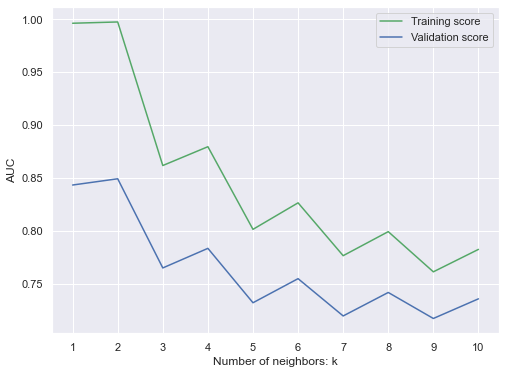

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.997655,0.849602,{'n_neighbors': 2}
2,0.996450,0.843702,{'n_neighbors': 1}
3,0.879881,0.783906,{'n_neighbors': 4}
4,0.862103,0.765415,{'n_neighbors': 3}
5,0.826883,0.755296,{'n_neighbors': 6}
6,0.799687,0.742257,{'n_neighbors': 8}
7,0.782930,0.736244,{'n_neighbors': 10}
8,0.801855,0.732556,{'n_neighbors': 5}
9,0.776990,0.720086,{'n_neighbors': 7}


In [24]:
k_range = list(range(1, 11))
param_grid = {'n_neighbors': k_range}

knn = KNeighborsClassifier()
knn_clf = GridSearchCV(knn,
                       param_grid,
                       scoring='precision',
                       return_train_score=True)
knn_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(knn_clf.cv_results_)
test_scores = np.array(results.mean_test_score)
train_scores = np.array(results.mean_train_score)
x_axis = k_range

# plot the mean cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_scores, label='Training score', c='g')
plt.plot(x_axis, test_scores, label='Validation score', c='b')
plt.xlabel('Number of neighbors: k')
plt.ylabel('AUC')
plt.xticks(range(1, len(k_range) + 1), k_range)
plt.legend()
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [25]:
print('Best Parameter: {}'.format(knn_clf.best_params_))
print('Average cross-validation score: {}'.format(knn_clf.best_score_))

Best Parameter: {'n_neighbors': 2}
Average cross-validation score: 0.8496023273906544


### Logistic Regression

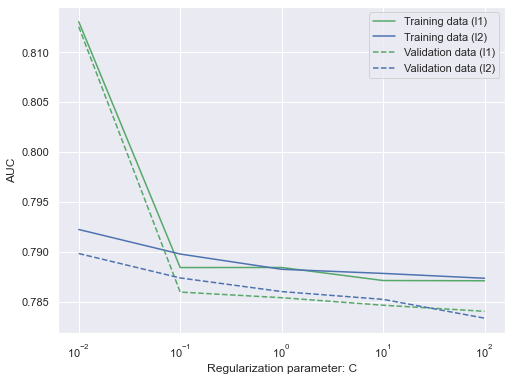

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.813063,0.812553,"{'C': 0.01, 'penalty': 'l1'}"
2,0.792233,0.789823,"{'C': 0.01, 'penalty': 'l2'}"
3,0.789773,0.787375,"{'C': 0.1, 'penalty': 'l2'}"
4,0.788243,0.786010,"{'C': 1, 'penalty': 'l2'}"
5,0.788417,0.785958,"{'C': 0.1, 'penalty': 'l1'}"
6,0.788424,0.785395,"{'C': 1, 'penalty': 'l1'}"
7,0.787830,0.785229,"{'C': 10, 'penalty': 'l2'}"
8,0.787118,0.784643,"{'C': 10, 'penalty': 'l1'}"
9,0.787092,0.784030,"{'C': 100, 'penalty': 'l1'}"


In [26]:
c_range = [0.01, 0.1, 1, 10, 100]
param_grid = {'C': c_range, 'penalty': ['l1', 'l2']}

logreg = LogisticRegression(solver='liblinear')
logreg_clf = GridSearchCV(logreg,
                          param_grid,
                          scoring='precision',
                          return_train_score=True)
logreg_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(logreg_clf.cv_results_)
test_scores = np.array(results.mean_test_score).reshape(5, 2)
train_scores = np.array(results.mean_train_score).reshape(5, 2)
x_axis = c_range

# plot the mean cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_scores[:, 0], label='Training data (l1)', color='g')
plt.plot(x_axis, train_scores[:, 1], label='Training data (l2)', color='b')
plt.plot(x_axis, test_scores[:, 0], label='Validation data (l1)', color='g', linestyle='dashed')
plt.plot(x_axis, test_scores[:, 1], label='Validation data (l2)', color='b', linestyle='dashed')
plt.legend()
plt.xscale('log')
plt.xlabel('Regularization parameter: C')
plt.ylabel('AUC')
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [27]:
print('Best Parameter: {}'.format(logreg_clf.best_params_))
print('Average cross-validation score: {}'.format(logreg_clf.best_score_))

Best Parameter: {'C': 0.01, 'penalty': 'l1'}
Average cross-validation score: 0.8125525424263209


### Linear Support Vector Machine

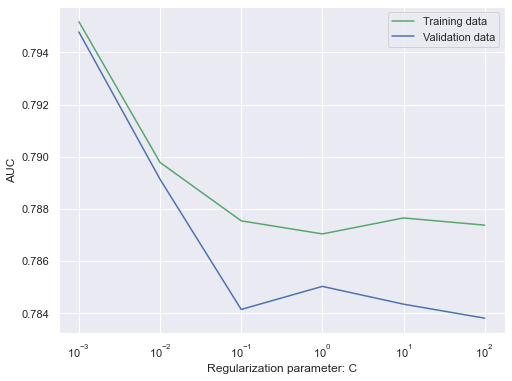

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.795180,0.794785,{'C': 0.001}
2,0.789782,0.789137,{'C': 0.01}
3,0.787040,0.785028,{'C': 1}
4,0.787653,0.784347,{'C': 10}
5,0.787543,0.784145,{'C': 0.1}
6,0.787377,0.783810,{'C': 100}


In [28]:
c_range = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C': c_range}
lsvc = LinearSVC(dual=False, random_state=0)
lsvc_clf = GridSearchCV(lsvc,
                        param_grid,
                        scoring='precision',
                        return_train_score=True)
lsvc_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(lsvc_clf.cv_results_)
test_scores = np.array(results.mean_test_score)
train_scores = np.array(results.mean_train_score)
x_axis = c_range

# plot the mean cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_scores, label='Training data', c='g')
plt.plot(x_axis, test_scores, label='Validation data', c='b')
plt.legend(loc='best')
plt.xlabel('Regularization parameter: C')
plt.ylabel('AUC')
plt.xscale('log')
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [29]:
print('Best Parameter: {}'.format(lsvc_clf.best_params_))
print('Average cross-validation score: {}'.format(lsvc_clf.best_score_))

Best Parameter: {'C': 0.001}
Average cross-validation score: 0.7947849671180995


### Kerenilzed Support Vector Machine
#### rbf

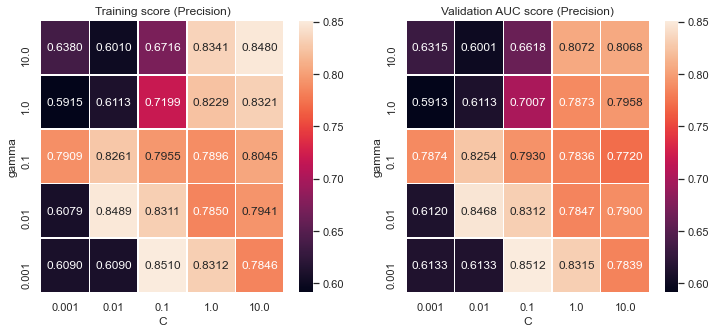

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.850993,0.851178,"{'C': 0.1, 'gamma': 0.001}"
2,0.848947,0.846755,"{'C': 0.01, 'gamma': 0.01}"
3,0.831184,0.831473,"{'C': 1, 'gamma': 0.001}"
4,0.831089,0.831179,"{'C': 0.1, 'gamma': 0.01}"
5,0.826063,0.825449,"{'C': 0.01, 'gamma': 0.1}"
6,0.834141,0.807175,"{'C': 1, 'gamma': 10}"
7,0.847980,0.806808,"{'C': 10, 'gamma': 10}"
8,0.832095,0.795817,"{'C': 10, 'gamma': 1}"
9,0.795529,0.793043,"{'C': 0.1, 'gamma': 0.1}"


In [30]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}
svc_rbf = SVC(kernel='rbf', random_state=0)
svc_rbf_clf = GridSearchCV(svc_rbf,
                           param_grid,
                           scoring='precision',
                           n_jobs=-1,
                           return_train_score=True)
svc_rbf_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(svc_rbf_clf.cv_results_)
test_scores = np.array(results.mean_test_score).reshape(5, 5)
test_scores = pd.DataFrame(test_scores.T[::-1],
                           index=param_grid['gamma'][::-1],
                           columns=param_grid['C'])
train_scores = np.array(results.mean_train_score).reshape(5, 5)
train_scores = pd.DataFrame(train_scores.T[::-1],
                            index=param_grid['gamma'][::-1],
                            columns=param_grid['C'])

# plot the mean cross-validation scores
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

plt.sca(axes[0])
sns.heatmap(train_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('C')
plt.ylabel('gamma')
plt.title('Training score (Precision)')

plt.sca(axes[1])
sns.heatmap(test_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('C')
plt.ylabel('gamma')
plt.title('Validation AUC score (Precision)')
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [31]:
print('Best Parameter: {}'.format(svc_rbf_clf.best_params_))
print('Average cross-validation score: {}'.format(svc_rbf_clf.best_score_))

Best Parameter: {'C': 0.1, 'gamma': 0.001}
Average cross-validation score: 0.8511777511061267


#### polynomial

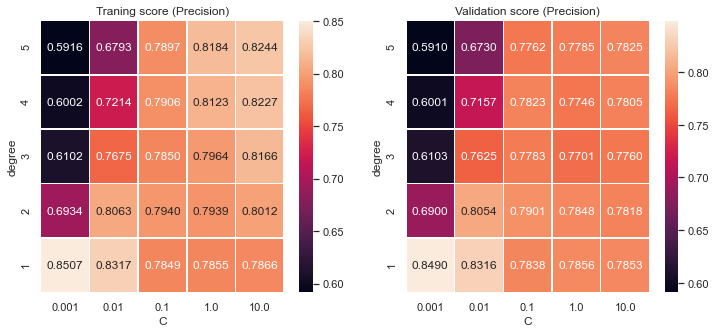

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.850670,0.848991,"{'C': 0.001, 'degree': 1}"
2,0.831743,0.831622,"{'C': 0.01, 'degree': 1}"
3,0.806256,0.805410,"{'C': 0.01, 'degree': 2}"
4,0.794049,0.790066,"{'C': 0.1, 'degree': 2}"
5,0.785537,0.785601,"{'C': 1, 'degree': 1}"
6,0.786577,0.785267,"{'C': 10, 'degree': 1}"
7,0.793886,0.784781,"{'C': 1, 'degree': 2}"
8,0.784922,0.783825,"{'C': 0.1, 'degree': 1}"
9,0.824395,0.782499,"{'C': 10, 'degree': 5}"


In [32]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'degree': [1, 2, 3, 4, 5]
}
svc_poly = SVC(kernel='poly', random_state=0)
svc_poly_clf = GridSearchCV(svc_poly,
                            param_grid,
                            scoring='precision',
                            return_train_score=True)
svc_poly_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(svc_poly_clf.cv_results_)
test_scores = np.array(results.mean_test_score).reshape(5, 5)
test_scores = pd.DataFrame(test_scores.T[::-1],
                           index=param_grid['degree'][::-1],
                           columns=param_grid['C'])
train_scores = np.array(results.mean_train_score).reshape(5, 5)
train_scores = pd.DataFrame(train_scores.T[::-1],
                            index=param_grid['degree'][::-1],
                            columns=param_grid['C'])

# plot the mean cross-validation scores
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

plt.sca(axes[0])
sns.heatmap(train_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('C')
plt.ylabel('degree')
plt.title('Traning score (Precision)')

plt.sca(axes[1])
sns.heatmap(test_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('C')
plt.ylabel('degree')
plt.title('Validation score (Precision)')
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [33]:
print('Best Parameter: {}'.format(svc_poly_clf.best_params_))
print('Average cross-validation score: {}'.format(svc_poly_clf.best_score_))

Best Parameter: {'C': 0.001, 'degree': 1}
Average cross-validation score: 0.8489905687240977


#### linear

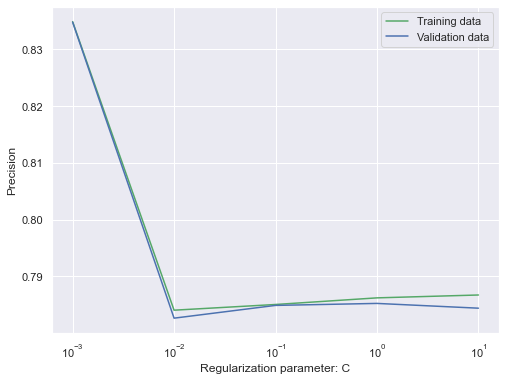

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.834878,0.834796,{'C': 0.001}
2,0.786234,0.785257,{'C': 1}
3,0.785067,0.784907,{'C': 0.1}
4,0.786740,0.784416,{'C': 10}
5,0.784064,0.782660,{'C': 0.01}


In [34]:
c_range = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': c_range}
svc_linear = SVC(kernel='linear', random_state=0)
svc_linear_clf = GridSearchCV(svc_linear,
                              param_grid,
                              scoring='precision',
                              return_train_score=True)
svc_linear_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(svc_linear_clf.cv_results_)
test_scores = np.array(results.mean_test_score)
train_scores = np.array(results.mean_train_score)
x_axis = c_range

# plot the mean cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_scores, label='Training data', c='g')
plt.plot(x_axis, test_scores, label='Validation data', c='b')
plt.legend()
plt.xlabel('Regularization parameter: C')
plt.ylabel('Precision')
plt.xscale('log')
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [35]:
print('Best Parameter: {}'.format(svc_linear_clf.best_params_))
print('Average cross-validation score: {}'.format(svc_linear_clf.best_score_))

Best Parameter: {'C': 0.001}
Average cross-validation score: 0.8347959047391951


### Decision Tree

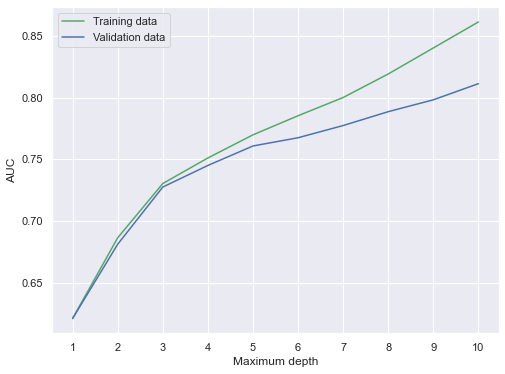

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.861160,0.811198,{'max_depth': 10}
2,0.840094,0.798139,{'max_depth': 9}
3,0.819048,0.788538,{'max_depth': 8}
4,0.800013,0.777324,{'max_depth': 7}
5,0.785253,0.767447,{'max_depth': 6}
6,0.769796,0.760791,{'max_depth': 5}
7,0.751083,0.745025,{'max_depth': 4}
8,0.730390,0.727559,{'max_depth': 3}
9,0.686508,0.681288,{'max_depth': 2}


In [36]:
depth = list(range(1, 11))
param_grid = {'max_depth': depth}
dtree = DecisionTreeClassifier(random_state=0)
dtree_clf = GridSearchCV(dtree,
                         param_grid,
                         scoring='roc_auc',
                         return_train_score=True)
dtree_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(dtree_clf.cv_results_)
test_scores = np.array(results.mean_test_score)
train_scores = np.array(results.mean_train_score)
x_axis = depth

# plot the mean cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_scores, label='Training data', c='g')
plt.plot(x_axis, test_scores, label='Validation data', c='b')
plt.xlabel('Maximum depth')
plt.ylabel('AUC')
plt.xticks(range(1, len(depth) + 1), depth)
plt.legend()
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [37]:
print('Best Parameter: {}'.format(dtree_clf.best_params_))
print('Average cross-validation score: {}'.format(dtree_clf.best_score_))

Best Parameter: {'max_depth': 10}
Average cross-validation score: 0.8111979097712041


## Prediction Based On Basic Classification Model

In [58]:
from sklearn.metrics import confusion_matrix

svc_rbf = SVC(C=0.1, gamma=0.001, kernel='rbf', random_state=0)
svc_rbf.fit(X_train, y_train)

y_pred = svc_rbf.predict(X_test)
confusion = confusion_matrix(y_test, y_pred)
conf_df = pd.DataFrame(confusion,
                       index=['True Negative', 'True Positive'],
                       columns=['Pred Negative', 'Pred Positive'])
TN = conf_df.iloc[0, 0]
FN = conf_df.iloc[1, 0]
FP = conf_df.iloc[0, 1]
TP = conf_df.iloc[1, 1]
acc = (TP + TN) / conf_df.sum().sum()
pre = TP / (TP + FP)
rec = TP / (TP + FN)
f1 = 2 * pre * rec / (pre + rec)
print(
    'Accuracy:{:.2%}\nPrecision:{:.2%}\nRecall:{:.2%}\nF-score:{:.2%}'.format(
        acc, pre, rec, f1))
conf_df

Accuracy:80.00%
Precision:63.13%
Recall:29.98%
F-score:40.65%


,Pred Negative,Pred Positive
True Negative,1463,80
True Positive,320,137


<font color='DARKGREEN'>__Summary__  
SVC with rbf kernel outperformed the other models in the end. It reported with 80% accuracy rate, which is also higher than the dummy classifier; 63.13% precision overall, which is deemed to the most important measure in our case, since the priority mission is to distinguish those risky customers as many as possible in our prediction.</font>

# Advanced Classification Model

## Voting Classifier

In [8]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA

__Hard Voting__

In [9]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
svc_clf = SVC(probability=True, random_state=0)
svc_clf.fit(X_train, y_train)
dtree_clf = DecisionTreeClassifier(random_state=0)
dtree_clf.fit(X_train, y_train)

voting_clf = VotingClassifier(estimators=[('knn', knn_clf), ('lr', log_clf),
                                          ('svc', svc_clf),
                                          ('dtree', dtree_clf)],
                              n_jobs=-1,
                              voting='hard')
voting_clf.fit(X_train, y_train)

print('-------accuracy-------')
for clf in (knn_clf, log_clf, svc_clf, dtree_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

print('\n-------precision-------')
for clf in (knn_clf, log_clf, svc_clf, dtree_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, precision_score(y_test, y_pred))

print('\n-------recall-------')
for clf in (knn_clf, log_clf, svc_clf, dtree_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, recall_score(y_test, y_pred))

print('\n-------f1-------')
for clf in (knn_clf, log_clf, svc_clf, dtree_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, f1_score(y_test, y_pred))

print('\n-------auc-------')
for clf in (knn_clf, log_clf, svc_clf, dtree_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, roc_auc_score(y_test, y_pred))

-------accuracy-------
KNeighborsClassifier 0.803
LogisticRegression 0.836
SVC 0.832
DecisionTreeClassifier 0.727
VotingClassifier 0.837

-------precision-------
KNeighborsClassifier 0.4864864864864865
LogisticRegression 0.6559139784946236
SVC 0.616822429906542
DecisionTreeClassifier 0.34
VotingClassifier 0.6704545454545454

-------recall-------
KNeighborsClassifier 0.37305699481865284
LogisticRegression 0.3160621761658031
SVC 0.34196891191709844
DecisionTreeClassifier 0.44041450777202074
VotingClassifier 0.30569948186528495

-------f1-------
KNeighborsClassifier 0.4222873900293255
LogisticRegression 0.42657342657342656
SVC 0.44
DecisionTreeClassifier 0.3837471783295711
VotingClassifier 0.4199288256227758

-------auc-------
KNeighborsClassifier 0.6394405172358444
LogisticRegression 0.6382045701151197
SVC 0.6455817298123285
DecisionTreeClassifier 0.617976770614635
VotingClassifier 0.6348819590243401


<font color='DARKGREEN'> __We can observe that hard voting classifier does a little improvement on accuracy and precision.__

__Soft Voting__

In [10]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
svc_clf = SVC(probability=True, random_state=0)
svc_clf.fit(X_train, y_train)
dtree_clf = DecisionTreeClassifier(random_state=0)
dtree_clf.fit(X_train, y_train)

voting_clf = VotingClassifier(estimators=[('knn', knn_clf), ('lr', log_clf),
                                          ('svc', svc_clf), ('dtree', dtree_clf)],
                              n_jobs=-1,
                              voting='soft')
voting_clf.fit(X_train, y_train)

print('-------accuracy-------')
for clf in (knn_clf, log_clf, svc_clf, dtree_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

print('\n-------precision-------')
for clf in (knn_clf, log_clf, svc_clf, dtree_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, precision_score(y_test, y_pred))

print('\n-------recall-------')
for clf in (knn_clf, log_clf, svc_clf, dtree_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, recall_score(y_test, y_pred))

print('\n-------f1-------')
for clf in (knn_clf, log_clf, svc_clf, dtree_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, f1_score(y_test, y_pred))

print('\n-------auc-------')
for clf in (knn_clf, log_clf, svc_clf, dtree_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, roc_auc_score(y_test, y_pred))

-------accuracy-------
KNeighborsClassifier 0.803
LogisticRegression 0.836
SVC 0.832
DecisionTreeClassifier 0.727
VotingClassifier 0.82

-------precision-------
KNeighborsClassifier 0.4864864864864865
LogisticRegression 0.6559139784946236
SVC 0.616822429906542
DecisionTreeClassifier 0.34
VotingClassifier 0.5575221238938053

-------recall-------
KNeighborsClassifier 0.37305699481865284
LogisticRegression 0.3160621761658031
SVC 0.34196891191709844
DecisionTreeClassifier 0.44041450777202074
VotingClassifier 0.32642487046632124

-------f1-------
KNeighborsClassifier 0.4222873900293255
LogisticRegression 0.42657342657342656
SVC 0.44
DecisionTreeClassifier 0.3837471783295711
VotingClassifier 0.41176470588235287

-------auc-------
KNeighborsClassifier 0.6394405172358444
LogisticRegression 0.6382045701151197
SVC 0.6455817298123285
DecisionTreeClassifier 0.617976770614635
VotingClassifier 0.6322335009085014


<font color='DARKGREEN'> __In the soft voting classifier, however, it doesn't put significant improvements on each evaluation criteria.__

## Bagging & Pasting

__Bagging__

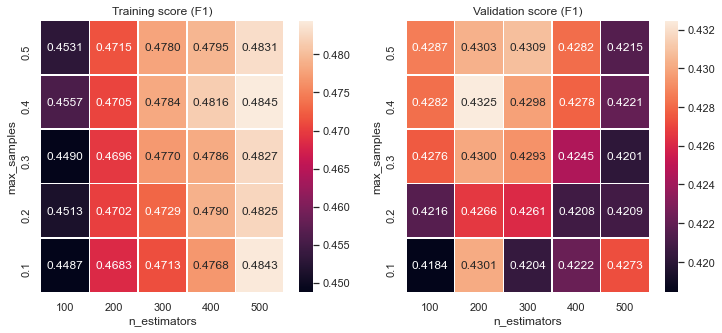

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.470540,0.432466,"{'max_samples': 0.2, 'n_estimators': 400}"
2,0.477982,0.430859,"{'max_samples': 0.3, 'n_estimators': 500}"
3,0.471522,0.430345,"{'max_samples': 0.2, 'n_estimators': 500}"
4,0.468290,0.430135,"{'max_samples': 0.2, 'n_estimators': 100}"
5,0.469647,0.430024,"{'max_samples': 0.2, 'n_estimators': 300}"
6,0.478375,0.429828,"{'max_samples': 0.3, 'n_estimators': 400}"
7,0.476993,0.429299,"{'max_samples': 0.3, 'n_estimators': 300}"
8,0.453056,0.428656,"{'max_samples': 0.1, 'n_estimators': 500}"
9,0.455732,0.428231,"{'max_samples': 0.1, 'n_estimators': 400}"


In [10]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5]
}

dtree = DecisionTreeClassifier(max_depth=4, random_state=0)
bag_dtree = BaggingClassifier(dtree, bootstrap=True, n_jobs=-1, random_state=0)
bag_dtree_clf = GridSearchCV(bag_dtree,
                             param_grid,
                             scoring='f1',
                             return_train_score=True,
                             n_jobs=-1)
bag_dtree_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(bag_dtree_clf.cv_results_)
test_scores = np.array(results.mean_test_score).reshape(5, 5)
test_scores = pd.DataFrame(test_scores.T[::-1],
                           index=param_grid['max_samples'][::-1],
                           columns=param_grid['n_estimators'])
train_scores = np.array(results.mean_train_score).reshape(5, 5)
train_scores = pd.DataFrame(train_scores.T[::-1],
                            index=param_grid['max_samples'][::-1],
                            columns=param_grid['n_estimators'])

# plot the mean cross-validation scores
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

plt.sca(axes[0])
sns.heatmap(train_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('n_estimators')
plt.ylabel('max_samples')
plt.title('Training score ({})'.format(bag_dtree_clf.scoring.capitalize()))

plt.sca(axes[1])
sns.heatmap(test_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('n_estimators')
plt.ylabel('max_samples')
plt.title('Validation score ({})'.format(bag_dtree_clf.scoring.capitalize()))
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [11]:
y_pred = bag_dtree_clf.predict(X_test)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.827
The precision score: 0.6086956521739131
The recall score: 0.29015544041450775
The f1 score: 0.3929824561403509
The auc score: 0.6227728874934991


<font color='DARKGREEN'> __The accuracy score comes to 82.7% in Bagging method, which is not bad. But we may be interested on its f1 score, since we're modeling an imbalance data. The auc score is also higher than 0.5, which means this model is better than a random predictor.__

__Pasting__

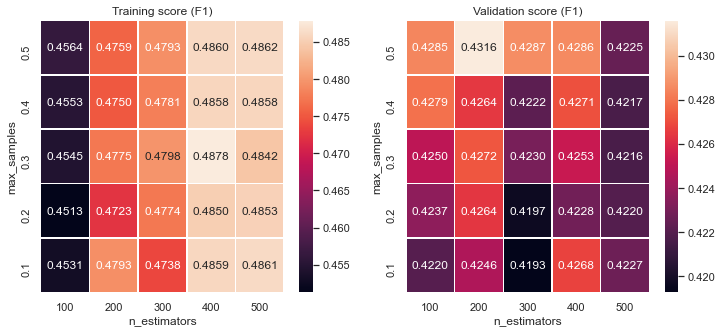

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.475876,0.431589,"{'max_samples': 0.2, 'n_estimators': 500}"
2,0.479278,0.428657,"{'max_samples': 0.3, 'n_estimators': 500}"
3,0.486045,0.428596,"{'max_samples': 0.4, 'n_estimators': 500}"
4,0.456396,0.428500,"{'max_samples': 0.1, 'n_estimators': 500}"
5,0.455284,0.427903,"{'max_samples': 0.1, 'n_estimators': 400}"
6,0.477489,0.427240,"{'max_samples': 0.2, 'n_estimators': 300}"
7,0.485823,0.427099,"{'max_samples': 0.4, 'n_estimators': 400}"
8,0.485919,0.426755,"{'max_samples': 0.4, 'n_estimators': 100}"
9,0.475026,0.426436,"{'max_samples': 0.2, 'n_estimators': 400}"


In [12]:
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5]
}

dtree = DecisionTreeClassifier(max_depth=4, random_state=0)
past_dtree = BaggingClassifier(dtree, bootstrap=False, n_jobs=-1, random_state=0)
past_dtree_clf = GridSearchCV(past_dtree,
                             param_grid,
                             scoring='f1',
                             return_train_score=True,
                             n_jobs=-1)
past_dtree_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(past_dtree_clf.cv_results_)
test_scores = np.array(results.mean_test_score).reshape(5, 5)
test_scores = pd.DataFrame(test_scores.T[::-1],
                           index=param_grid['max_samples'][::-1],
                           columns=param_grid['n_estimators'])
train_scores = np.array(results.mean_train_score).reshape(5, 5)
train_scores = pd.DataFrame(train_scores.T[::-1],
                            index=param_grid['max_samples'][::-1],
                            columns=param_grid['n_estimators'])

# plot the mean cross-validation scores
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

plt.sca(axes[0])
sns.heatmap(train_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('n_estimators')
plt.ylabel('max_samples')
plt.title('Training score ({})'.format(past_dtree_clf.scoring.capitalize()))

plt.sca(axes[1])
sns.heatmap(test_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('n_estimators')
plt.ylabel('max_samples')
plt.title('Validation score ({})'.format(past_dtree_clf.scoring.capitalize()))
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [13]:
y_pred = past_dtree_clf.predict(X_test)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.826
The precision score: 0.6021505376344086
The recall score: 0.29015544041450775
The f1 score: 0.39160839160839156
The auc score: 0.622153308807006


<font color='DARKGREEN'> __The results are slightly lower than the Bagging method.__

## AdaBoost

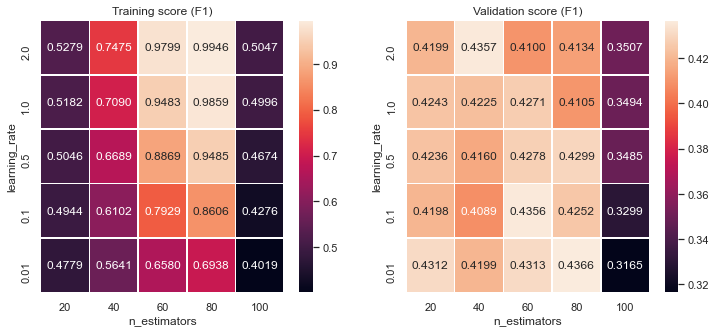

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.693835,0.436565,"{'learning_rate': 1, 'n_estimators': 20}"
2,0.747501,0.435697,"{'learning_rate': 0.1, 'n_estimators': 100}"
3,0.792870,0.435637,"{'learning_rate': 0.5, 'n_estimators': 40}"
4,0.658021,0.431275,"{'learning_rate': 0.5, 'n_estimators': 20}"
5,0.477910,0.431233,"{'learning_rate': 0.01, 'n_estimators': 20}"
6,0.948460,0.429857,"{'learning_rate': 1, 'n_estimators': 60}"
7,0.886910,0.427773,"{'learning_rate': 0.5, 'n_estimators': 60}"
8,0.948302,0.427065,"{'learning_rate': 0.5, 'n_estimators': 80}"
9,0.860645,0.425160,"{'learning_rate': 1, 'n_estimators': 40}"


In [14]:
param_grid = {
    'n_estimators': [20, 40, 60, 80, 100],
    'learning_rate': [0.01, 0.1, 0.5, 1, 2]
}
dtree = DecisionTreeClassifier(max_depth=4, random_state=0)
ada_dtree = AdaBoostClassifier(dtree, algorithm="SAMME.R", random_state=0)
ada_dtree_clf = GridSearchCV(ada_dtree,
                             param_grid,
                             scoring='f1',
                             return_train_score=True,
                             n_jobs=-1)
ada_dtree_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(ada_dtree_clf.cv_results_)
test_scores = np.array(results.mean_test_score).reshape(5, 5)
test_scores = pd.DataFrame(test_scores.T[::-1],
                           index=param_grid['learning_rate'][::-1],
                           columns=param_grid['n_estimators'])
train_scores = np.array(results.mean_train_score).reshape(5, 5)
train_scores = pd.DataFrame(train_scores.T[::-1],
                            index=param_grid['learning_rate'][::-1],
                            columns=param_grid['n_estimators'])

# plot the mean cross-validation scores
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

plt.sca(axes[0])
sns.heatmap(train_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.title('Training score ({})'.format(ada_dtree_clf.scoring.capitalize()))

plt.sca(axes[1])
sns.heatmap(test_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.title('Validation score ({})'.format(ada_dtree_clf.scoring.capitalize()))
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [15]:
y_pred = ada_dtree_clf.predict(X_test)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.792
The precision score: 0.45454545454545453
The recall score: 0.38860103626943004
The f1 score: 0.41899441340782123
The auc score: 0.6385384363503284


<font color='DARKGREEN'> __We lost a little accuracy score here, but gain more on f1 score.__

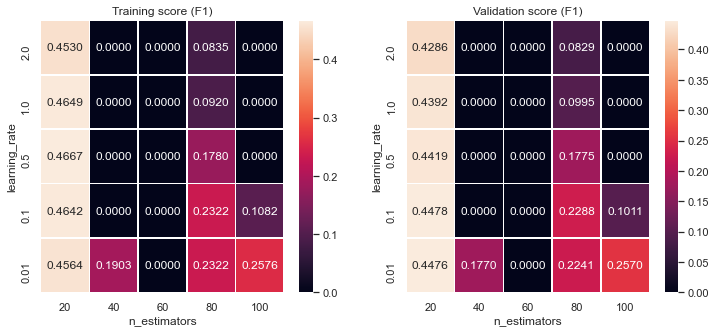

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.464183,0.447752,"{'learning_rate': 0.01, 'n_estimators': 40}"
2,0.456353,0.447645,"{'learning_rate': 0.01, 'n_estimators': 20}"
3,0.466717,0.441905,"{'learning_rate': 0.01, 'n_estimators': 60}"
4,0.464876,0.439208,"{'learning_rate': 0.01, 'n_estimators': 80}"
5,0.453033,0.428647,"{'learning_rate': 0.01, 'n_estimators': 100}"
6,0.257578,0.257016,"{'learning_rate': 2, 'n_estimators': 20}"
7,0.232177,0.228778,"{'learning_rate': 1, 'n_estimators': 40}"
8,0.232237,0.224103,"{'learning_rate': 1, 'n_estimators': 20}"
9,0.178030,0.177456,"{'learning_rate': 1, 'n_estimators': 60}"


In [16]:
param_grid = {
    'n_estimators': [20, 40, 60, 80, 100],
    'learning_rate': [0.01, 0.1, 0.5, 1, 2]
}
svc = SVC(kernel='rbf', probability=True, random_state=0)
ada_svc = AdaBoostClassifier(svc, algorithm="SAMME.R", random_state=0)
ada_svc_clf = GridSearchCV(ada_svc,
                           param_grid,
                           scoring='f1',
                           return_train_score=True,
                           n_jobs=-1)
ada_svc_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(ada_svc_clf.cv_results_)
test_scores = np.array(results.mean_test_score).reshape(5, 5)
test_scores = pd.DataFrame(test_scores.T[::-1],
                           index=param_grid['learning_rate'][::-1],
                           columns=param_grid['n_estimators'])
train_scores = np.array(results.mean_train_score).reshape(5, 5)
train_scores = pd.DataFrame(train_scores.T[::-1],
                            index=param_grid['learning_rate'][::-1],
                            columns=param_grid['n_estimators'])

# plot the mean cross-validation scores
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

plt.sca(axes[0])
sns.heatmap(train_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.title('Training score ({})'.format(ada_dtree_clf.scoring.capitalize()))

plt.sca(axes[1])
sns.heatmap(test_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('n_estimators')
plt.ylabel('learning_rate')
plt.title('Validation score ({})'.format(ada_dtree_clf.scoring.capitalize()))
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [17]:
y_pred = ada_svc_clf.predict(X_test)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.831
The precision score: 0.6224489795918368
The recall score: 0.3160621761658031
The f1 score: 0.41924398625429554
The auc score: 0.6351066766826537


<font color='DARKGREEN'> __Comparing to Decision Tree with AdaBoost method, SVC wins on almost scoring functions (except recall). It gets a relatively high accuracy score, f1 score, and auc score.__

## Gradient Boosting

In [18]:
from sklearn.ensemble import GradientBoostingClassifier

param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.01, 0.1, 0.5, 1]
}
gbrt = GradientBoostingClassifier(random_state=0)
gbrt_clf = GridSearchCV(gbrt,
                        param_grid,
                        scoring='f1',
                        return_train_score=True,
                        n_jobs=-1)
gbrt_clf.fit(X_train, y_train)

# view the complete results
results = pd.DataFrame(gbrt_clf.cv_results_)
test_scores = np.array(results.mean_test_score)
train_scores = np.array(results.mean_train_score)

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.980545,0.464144,"{'learning_rate': 0.5, 'n_estimators': 400}"
2,0.613730,0.461507,"{'learning_rate': 0.1, 'n_estimators': 200}"
3,0.723265,0.459637,"{'learning_rate': 0.1, 'n_estimators': 400}"
4,0.667983,0.456941,"{'learning_rate': 0.1, 'n_estimators': 300}"
5,0.993651,0.456059,"{'learning_rate': 1, 'n_estimators': 300}"
6,0.995417,0.455746,"{'learning_rate': 1, 'n_estimators': 400}"
7,0.967359,0.453889,"{'learning_rate': 0.5, 'n_estimators': 300}"
8,0.923427,0.452816,"{'learning_rate': 0.5, 'n_estimators': 200}"
9,0.981957,0.448864,"{'learning_rate': 1, 'n_estimators': 200}"


In [19]:
y_pred = gbrt_clf.predict(X_test)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.8
The precision score: 0.4797687861271676
The recall score: 0.43005181347150256
The f1 score: 0.453551912568306
The auc score: 0.6592638249513647


<font color='DARKGREEN'> __The recall, f1, and auc score are all gaining a great improvement by using gradient boosting method.__

## PCA

In [20]:
pca = PCA(n_components=0.9)

X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

X_train_PCA.shape

(4000, 13)

<font color='DARKGREEN'> __After applying PCA, the dimension of our dataset is reduced from 62 to 13 features with maintaining 90% of explanation of variance.__

### KNN with PCA

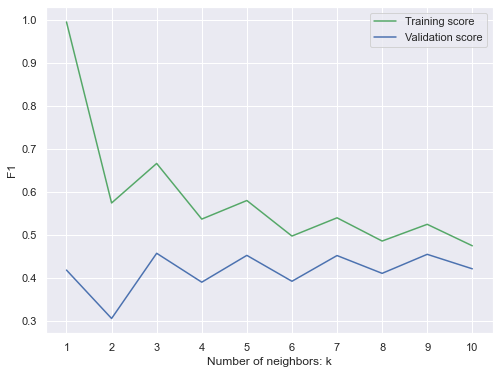

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.666045,0.457485,{'n_neighbors': 3}
2,0.524710,0.455042,{'n_neighbors': 9}
3,0.579975,0.452632,{'n_neighbors': 5}
4,0.539819,0.452205,{'n_neighbors': 7}
5,0.474866,0.421430,{'n_neighbors': 10}
6,0.994469,0.418473,{'n_neighbors': 1}
7,0.485885,0.410891,{'n_neighbors': 8}
8,0.497473,0.392501,{'n_neighbors': 6}
9,0.536839,0.390389,{'n_neighbors': 4}


In [21]:
k_range = list(range(1, 11))
param_grid = {'n_neighbors': k_range}

knn = KNeighborsClassifier()
knn_clf = GridSearchCV(knn,
                       param_grid,
                       scoring='f1',
                       return_train_score=True)
knn_clf.fit(X_train_PCA, y_train)

# view the complete results
results = pd.DataFrame(knn_clf.cv_results_)
test_scores = np.array(results.mean_test_score)
train_scores = np.array(results.mean_train_score)
x_axis = k_range

# plot the mean cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_scores, label='Training score', c='g')
plt.plot(x_axis, test_scores, label='Validation score', c='b')
plt.xlabel('Number of neighbors: k')
plt.ylabel(knn_clf.scoring.capitalize())
plt.xticks(range(1, len(k_range) + 1), k_range)
plt.legend()
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [22]:
y_pred = knn_clf.predict(X_test_PCA)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))


The accuracy score: 0.789
The precision score: 0.45108695652173914
The recall score: 0.43005181347150256
The f1 score: 0.4403183023872679
The auc score: 0.6524484593999396


|             | accuracy | precision | recall |   f1   |   auc  |
|:-----------:|:--------:|:---------:|:------:|:------:|:------:|
| without PCA |  0.7230  |   0.3205  | 0.3886 | 0.3513 | 0.5958 |
|   with PCA  |  0.7890  |   0.4511  | 0.4301 | 0.4403 | 0.6524 |

<font color='DARKGREEN'> __In KNN method, all the evaluation scores are improved.__

### Logistic Regression with PCA

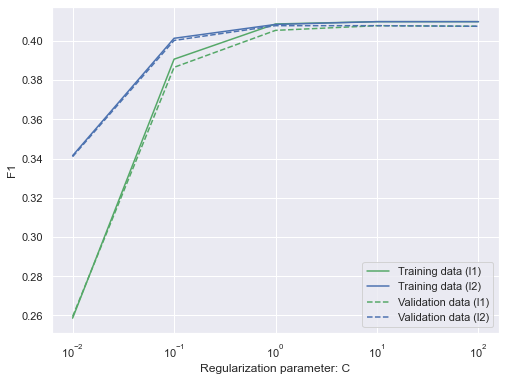

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.408393,0.407755,"{'C': 1, 'penalty': 'l2'}"
1,0.409812,0.407755,"{'C': 10, 'penalty': 'l1'}"
1,0.409812,0.407755,"{'C': 10, 'penalty': 'l2'}"
4,0.409812,0.407455,"{'C': 100, 'penalty': 'l1'}"
4,0.409812,0.407455,"{'C': 100, 'penalty': 'l2'}"
6,0.408624,0.405369,"{'C': 1, 'penalty': 'l1'}"
7,0.401325,0.400235,"{'C': 0.1, 'penalty': 'l2'}"
8,0.390669,0.386518,"{'C': 0.1, 'penalty': 'l1'}"
9,0.341484,0.340932,"{'C': 0.01, 'penalty': 'l2'}"


In [23]:
c_range = [0.01, 0.1, 1, 10, 100]
param_grid = {'C': c_range, 'penalty': ['l1', 'l2']}

logreg = LogisticRegression(solver='liblinear')
logreg_clf = GridSearchCV(logreg,
                          param_grid,
                          scoring='f1',
                          return_train_score=True)
logreg_clf.fit(X_train_PCA, y_train)

# view the complete results
results = pd.DataFrame(logreg_clf.cv_results_)
test_scores = np.array(results.mean_test_score).reshape(5, 2)
train_scores = np.array(results.mean_train_score).reshape(5, 2)
x_axis = c_range

# plot the mean cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_scores[:, 0], label='Training data (l1)', color='g')
plt.plot(x_axis, train_scores[:, 1], label='Training data (l2)', color='b')
plt.plot(x_axis, test_scores[:, 0], label='Validation data (l1)', color='g', linestyle='dashed')
plt.plot(x_axis, test_scores[:, 1], label='Validation data (l2)', color='b', linestyle='dashed')
plt.legend()
plt.xscale('log')
plt.xlabel('Regularization parameter: C')
plt.ylabel(logreg_clf.scoring.capitalize())
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [24]:
y_pred = logreg_clf.predict(X_test_PCA)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.829
The precision score: 0.6309523809523809
The recall score: 0.27461139896373055
The f1 score: 0.3826714801444043
The auc score: 0.6180987602005765


|             | accuracy | precision | recall |   f1   |   auc  |
|:-----------:|:--------:|:---------:|:------:|:------:|:------:|
| without PCA |  0.8340  |   0.6452  | 0.3109 | 0.4196 | 0.6350 |
|   with PCA  |  0.8290  |   0.6310  | 0.2746 | 0.3827 | 0.6181 |

<font color='DARKGREEN'> __In Logistic Regression, all the scores are decreasing.__

### Linear Support Vector Classifier with PCA


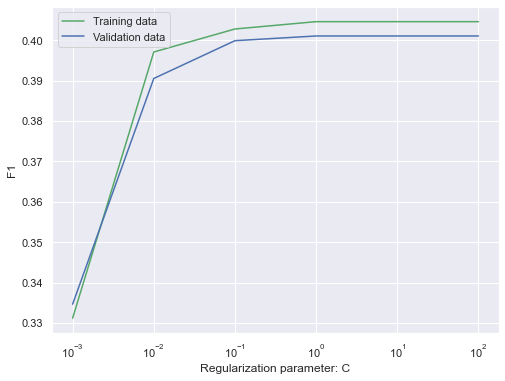

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.404612,0.401067,{'C': 1}
1,0.404612,0.401067,{'C': 10}
1,0.404612,0.401067,{'C': 100}
4,0.402794,0.399901,{'C': 0.1}
5,0.397102,0.390547,{'C': 0.01}
6,0.331218,0.334677,{'C': 0.001}


In [25]:
c_range = [0.001, 0.01, 0.1, 1, 10, 100]
param_grid = {'C': c_range}
lsvc = LinearSVC(dual=False, random_state=0)
lsvc_clf = GridSearchCV(lsvc,
                        param_grid,
                        scoring='f1',
                        return_train_score=True)
lsvc_clf.fit(X_train_PCA, y_train)

# view the complete results
results = pd.DataFrame(lsvc_clf.cv_results_)
test_scores = np.array(results.mean_test_score)
train_scores = np.array(results.mean_train_score)
x_axis = c_range

# plot the mean cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_scores, label='Training data', c='g')
plt.plot(x_axis, test_scores, label='Validation data', c='b')
plt.legend(loc='best')
plt.xlabel('Regularization parameter: C')
plt.ylabel(lsvc_clf.scoring.capitalize())
plt.xscale('log')
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [26]:
y_pred = lsvc_clf.predict(X_test_PCA)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.829
The precision score: 0.6341463414634146
The recall score: 0.2694300518134715
The f1 score: 0.37818181818181823
The auc score: 0.6161276653119402


|             | accuracy | precision | recall |   f1   |   auc  |
|:-----------:|:--------:|:---------:|:------:|:------:|:------:|
| without PCA |  0.8070  |   0.0000  | 0.0000 | 0.0000 | 0.5000 |
|   with PCA  |  0.8290  |   0.6341  | 0.2694 | 0.3782 | 0.6161 |

<font color='DARKGREEN'> __In Linear Vector Classifier, all the scores are improved.__

### Kernelized Support Vector Classifier with PCA
#### Linear

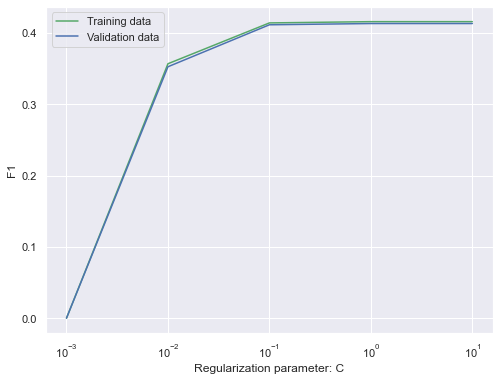

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.415853,0.413215,{'C': 1}
1,0.415853,0.413215,{'C': 10}
3,0.414090,0.411459,{'C': 0.1}
4,0.356823,0.352601,{'C': 0.01}
5,0.000000,0.000000,{'C': 0.001}


In [27]:
c_range = [0.001, 0.01, 0.1, 1, 10]
param_grid = {'C': c_range}
svc_linear = SVC(kernel='linear', random_state=0)
svc_linear_clf = GridSearchCV(svc_linear,
                              param_grid,
                              scoring='f1',
                              return_train_score=True,
                              n_jobs=-1)
svc_linear_clf.fit(X_train_PCA, y_train)

# view the complete results
results = pd.DataFrame(svc_linear_clf.cv_results_)
test_scores = np.array(results.mean_test_score)
train_scores = np.array(results.mean_train_score)
x_axis = c_range

# plot the mean cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_scores, label='Training data', c='g')
plt.plot(x_axis, test_scores, label='Validation data', c='b')
plt.legend()
plt.xlabel('Regularization parameter: C')
plt.ylabel(svc_linear_clf.scoring.capitalize())
plt.xscale('log')
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [28]:
y_pred = svc_linear_clf.predict(X_test_PCA)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.827
The precision score: 0.6282051282051282
The recall score: 0.2538860103626943
The f1 score: 0.3616236162361624
The auc score: 0.6089752232730449


|             | accuracy | precision | recall |   f1   |   auc  |
|:-----------:|:--------:|:---------:|:------:|:------:|:------:|
| without PCA |  0.7810  |   0.3649  | 0.1813 | 0.2422 | 0.5529 |
|   with PCA  |  0.8270  |   0.6282  | 0.2539 | 0.3616 | 0.6090 |

<font color='DARKGREEN'> __In SVC with linear kernel, all the scores are improved.__

#### RBF

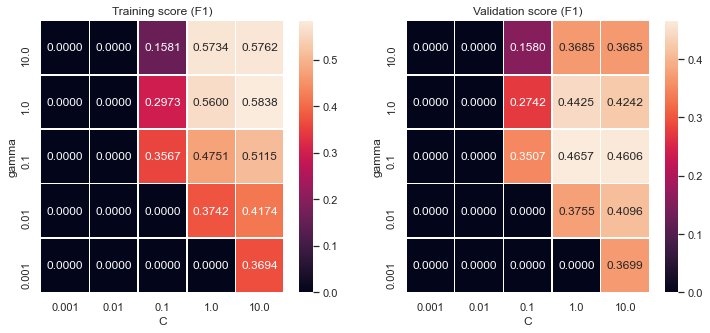

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.475090,0.465720,"{'C': 1, 'gamma': 0.1}"
2,0.511535,0.460624,"{'C': 10, 'gamma': 0.1}"
3,0.560003,0.442522,"{'C': 1, 'gamma': 1}"
4,0.583770,0.424231,"{'C': 10, 'gamma': 1}"
5,0.417353,0.409613,"{'C': 10, 'gamma': 0.01}"
6,0.374207,0.375523,"{'C': 1, 'gamma': 0.01}"
7,0.369386,0.369859,"{'C': 10, 'gamma': 0.001}"
8,0.576190,0.368495,"{'C': 10, 'gamma': 10}"
8,0.573360,0.368495,"{'C': 1, 'gamma': 10}"


In [29]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'gamma': [0.001, 0.01, 0.1, 1, 10]
}
svc_rbf = SVC(kernel='rbf', random_state=0)
svc_rbf_clf = GridSearchCV(svc_rbf,
                           param_grid,
                           scoring='f1',
                           n_jobs=-1,
                           return_train_score=True)
svc_rbf_clf.fit(X_train_PCA, y_train)

# view the complete results
results = pd.DataFrame(svc_rbf_clf.cv_results_)
test_scores = np.array(results.mean_test_score).reshape(5, 5)
test_scores = pd.DataFrame(test_scores.T[::-1],
                           index=param_grid['gamma'][::-1],
                           columns=param_grid['C'])
train_scores = np.array(results.mean_train_score).reshape(5, 5)
train_scores = pd.DataFrame(train_scores.T[::-1],
                            index=param_grid['gamma'][::-1],
                            columns=param_grid['C'])

# plot the mean cross-validation scores
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

plt.sca(axes[0])
sns.heatmap(train_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('C')
plt.ylabel('gamma')
plt.title('Training score ({})'.format(ada_dtree_clf.scoring.capitalize()))

plt.sca(axes[1])
sns.heatmap(test_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('C')
plt.ylabel('gamma')
plt.title('Validation score ({})'.format(ada_dtree_clf.scoring.capitalize()))
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [30]:
y_pred = svc_rbf_clf.predict(X_test_PCA)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.829
The precision score: 0.6
The recall score: 0.34196891191709844
The f1 score: 0.43564356435643564
The auc score: 0.643722993752849


|             | accuracy | precision | recall |   f1   |   auc  |
|:-----------:|:--------:|:---------:|:------:|:------:|:------:|
| without PCA |  0.8120  |   0.6190  | 0.0674 | 0.1215 | 0.5287 |
|   with PCA  |  0.8290  |   0.6000  | 0.3420 | 0.4356 | 0.6437 |

<font color='DARKGREEN'> __In SVC with rbf kernel, only the precision is slightly decreased.__

#### Polynomial

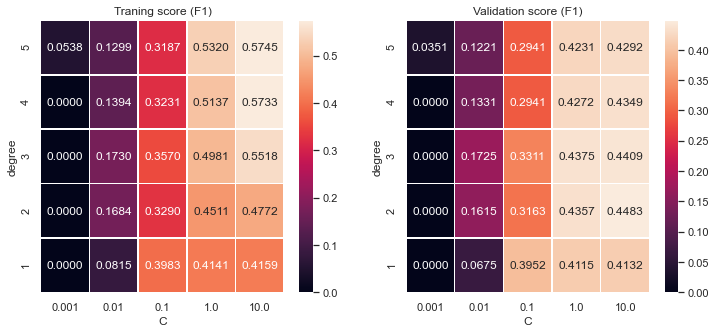

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.477225,0.448278,"{'C': 10, 'degree': 2}"
2,0.551850,0.440897,"{'C': 10, 'degree': 3}"
3,0.498068,0.437543,"{'C': 1, 'degree': 3}"
4,0.451097,0.435678,"{'C': 1, 'degree': 2}"
5,0.573320,0.434944,"{'C': 10, 'degree': 4}"
6,0.574501,0.429249,"{'C': 10, 'degree': 5}"
7,0.513669,0.427227,"{'C': 1, 'degree': 4}"
8,0.532030,0.423053,"{'C': 1, 'degree': 5}"
9,0.415853,0.413215,"{'C': 10, 'degree': 1}"


In [31]:
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'degree': [1, 2, 3, 4, 5]
}
svc_poly = SVC(kernel='poly', random_state=0)
svc_poly_clf = GridSearchCV(svc_poly,
                            param_grid,
                            scoring='f1',
                            return_train_score=True, n_jobs=-1)
svc_poly_clf.fit(X_train_PCA, y_train)

# view the complete results
results = pd.DataFrame(svc_poly_clf.cv_results_)
test_scores = np.array(results.mean_test_score).reshape(5, 5)
test_scores = pd.DataFrame(test_scores.T[::-1],
                           index=param_grid['degree'][::-1],
                           columns=param_grid['C'])
train_scores = np.array(results.mean_train_score).reshape(5, 5)
train_scores = pd.DataFrame(train_scores.T[::-1],
                            index=param_grid['degree'][::-1],
                            columns=param_grid['C'])

# plot the mean cross-validation scores
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

plt.sca(axes[0])
sns.heatmap(train_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('C')
plt.ylabel('degree')
plt.title('Traning score ({})'.format(ada_dtree_clf.scoring.capitalize()))

plt.sca(axes[1])
sns.heatmap(test_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('C')
plt.ylabel('degree')
plt.title('Validation score ({})'.format(ada_dtree_clf.scoring.capitalize()))
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [32]:
y_pred = svc_poly_clf.predict(X_test_PCA)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.824
The precision score: 0.5752212389380531
The recall score: 0.33678756476683935
The f1 score: 0.42483660130718953
The auc score: 0.6386540054317468


|             | accuracy | precision | recall |   f1   |   auc  |
|:-----------:|:--------:|:---------:|:------:|:------:|:------:|
| without PCA |  0.8050  |   0.0000  | 0.0000 | 0.0000 | 0.4988 |
|   with PCA  |  0.8240  |   0.5752  | 0.3368 | 0.4248 | 0.6387 |

<font color='DARKGREEN'> __In SVC with polynomial kernel, all the scores are improved.__

### Decision Tree with PCA

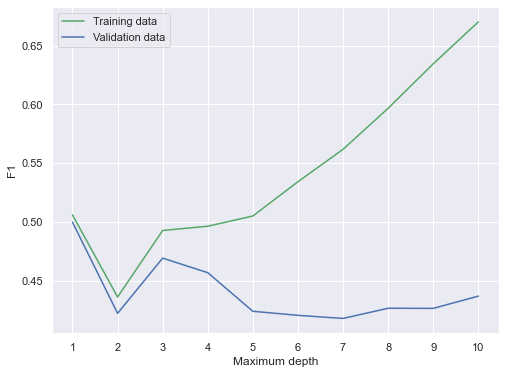

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.506037,0.499837,{'max_depth': 1}
2,0.492793,0.469285,{'max_depth': 3}
3,0.496422,0.456921,{'max_depth': 4}
4,0.670137,0.436997,{'max_depth': 10}
5,0.596714,0.426675,{'max_depth': 8}
6,0.634484,0.426558,{'max_depth': 9}
7,0.505099,0.424087,{'max_depth': 5}
8,0.436244,0.422320,{'max_depth': 2}
9,0.534252,0.420647,{'max_depth': 6}


In [33]:
depth = list(range(1, 11))
param_grid = {'max_depth': depth}
dtree = DecisionTreeClassifier(random_state=0)
dtree_clf = GridSearchCV(dtree,
                         param_grid,
                         scoring='f1',
                         return_train_score=True,
                         n_jobs=-1)
dtree_clf.fit(X_train_PCA, y_train)

# view the complete results
results = pd.DataFrame(dtree_clf.cv_results_)
test_scores = np.array(results.mean_test_score)
train_scores = np.array(results.mean_train_score)
x_axis = depth

# plot the mean cross-validation scores
plt.figure(figsize=(8, 6))
plt.plot(x_axis, train_scores, label='Training data', c='g')
plt.plot(x_axis, test_scores, label='Validation data', c='b')
plt.xlabel('Maximum depth')
plt.ylabel(dtree_clf.scoring.capitalize())
plt.xticks(range(1, len(depth) + 1), depth)
plt.legend()
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [34]:
y_pred = dtree_clf.predict(X_test_PCA)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.791
The precision score: 0.4595959595959596
The recall score: 0.47150259067357514
The f1 score: 0.4654731457800511
The auc score: 0.6694563758820168


|             | accuracy | precision | recall |   f1   |   auc  |
|:-----------:|:--------:|:---------:|:------:|:------:|:------:|
| without PCA |  0.8180  |   0.5534  | 0.2953 | 0.3851 | 0.6192 |
|   with PCA  |  0.7910  |   0.4596  | 0.4715 | 0.4655 | 0.6695 |

<font color='DARKGREEN'> __In Decision Tree, only recall and auc scores are improved.__

<font color='DARKBLUE'> __Overall speaking, PCA helps improve the results on mostly models, only a few models are getting worse. But people says, no models are correct, some models are useful. The final model should be decided based on the scenario needs.__

## Deep Learning

In [101]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

In [110]:
def create_model():
    #create model
    model = Sequential()
    model.add(Dense(12, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    #compile model
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

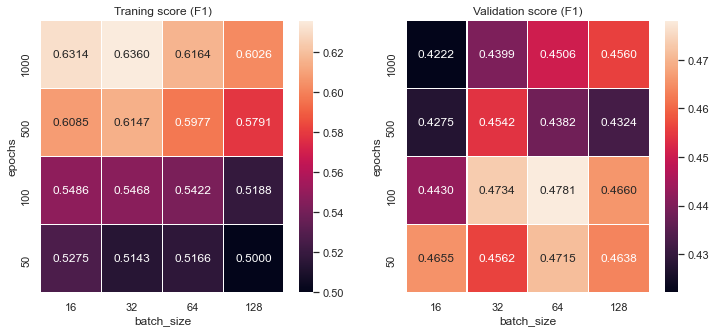

,mean_train_score,mean_test_score,params
rank_test_score,,,
1,0.542245,0.478098,"{'batch_size': 64, 'epochs': 100}"
2,0.546791,0.473418,"{'batch_size': 32, 'epochs': 100}"
3,0.516617,0.471523,"{'batch_size': 64, 'epochs': 50}"
4,0.518777,0.466025,"{'batch_size': 128, 'epochs': 100}"
5,0.527479,0.465504,"{'batch_size': 16, 'epochs': 50}"
6,0.499987,0.463806,"{'batch_size': 128, 'epochs': 50}"
7,0.514330,0.456177,"{'batch_size': 32, 'epochs': 50}"
8,0.602635,0.456032,"{'batch_size': 128, 'epochs': 1000}"
9,0.614748,0.454192,"{'batch_size': 32, 'epochs': 500}"


In [112]:
np.random.seed(0)

model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {'batch_size': [16, 32, 64, 128], 'epochs': [50, 100, 500, 1000]}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           return_train_score=True,
                           scoring='f1',
                           n_jobs=-1)
grid_search_result = grid_search.fit(X_train, y_train)
results = pd.DataFrame(grid_search_result.cv_results_)

# view the complete results
results = pd.DataFrame(grid_search_result.cv_results_)
test_scores = np.array(results.mean_test_score).reshape(4, 4)
test_scores = pd.DataFrame(test_scores.T[::-1],
                           index=param_grid['epochs'][::-1],
                           columns=param_grid['batch_size'])
train_scores = np.array(results.mean_train_score).reshape(4, 4)
train_scores = pd.DataFrame(train_scores.T[::-1],
                            index=param_grid['epochs'][::-1],
                            columns=param_grid['batch_size'])

# plot the mean cross-validation scores
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 5))

plt.sca(axes[0])
sns.heatmap(train_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('batch_size')
plt.ylabel('epochs')
plt.title('Traning score ({})'.format(grid_search_result.scoring.capitalize()))

plt.sca(axes[1])
sns.heatmap(test_scores, annot=True, fmt='.4f', linewidths=.5)
plt.xlabel('batch_size')
plt.ylabel('epochs')
plt.title('Validation score ({})'.format(grid_search_result.scoring.capitalize()))
plt.show()

results.set_index(['rank_test_score']).sort_index()[[
    'mean_train_score', 'mean_test_score', 'params'
]]

In [113]:
y_pred = grid_search_result.predict(X_test)

print('The accuracy score: {}'.format(accuracy_score(y_test, y_pred)))
print('The precision score: {}'.format(precision_score(y_test, y_pred)))
print('The recall score: {}'.format(recall_score(y_test, y_pred)))
print('The f1 score: {}'.format(f1_score(y_test, y_pred)))
print('The auc score: {}'.format(roc_auc_score(y_test, y_pred)))

The accuracy score: 0.825
The precision score: 0.576271186440678
The recall score: 0.35233160621761656
The f1 score: 0.43729903536977494
The auc score: 0.645186868784149


<font color='DARKGREEN'> __Surprisingly, Deep Learning is not the best model in this case.__

<font color='DARKGREEN'>__Summary__  
In this case, we were facing several issues from the beginning, and were all solved by the following actions:
 1. Ambiguous data - Contact the source data provider for detailed information.
2. Imbalanced data - Implement oversampling technique to get a better result.
3. Computational barrier - Adapt fewer rows to the time consuming model, e.g. support machine model.</font>